<h1><center> Lab 5: Network (Data) Science and Assignment 2 Support </center></h1>

Assignment 2 will combine supervised learning on networks with an essay to reflect on the ethical implications of data science. In this notebook, you can practice with network analysis (community detection and link prediction).

You can also use parts of this notebook as a starting point for your assignment: the final part of this notebook can help you to import network data, perform feature engineering and output your predictions.

<h2> Community detection </h2>

The first task we will consider is community detection. This is one example of unsupervised learning with network data. Community detection methods are helpful to detect communities (also known as clusters of modules) based on network structure, such as strongly connected groups of nodes: groups of friends in social, academic sub-communities in co-authorship networks, groups of related web-pages, groups of functionally similar units in metabolic networks.

Here you'll find some portions of code that you can use to perform Community Detection analysis (discussed in [Lecture 7](https://canvas.uva.nl/courses/45979/files/11537488?module_item_id=2187507)). We're going to use the example of the Zachary's Karate Club introduced in Lecture 8. You can find more details about this example [here](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

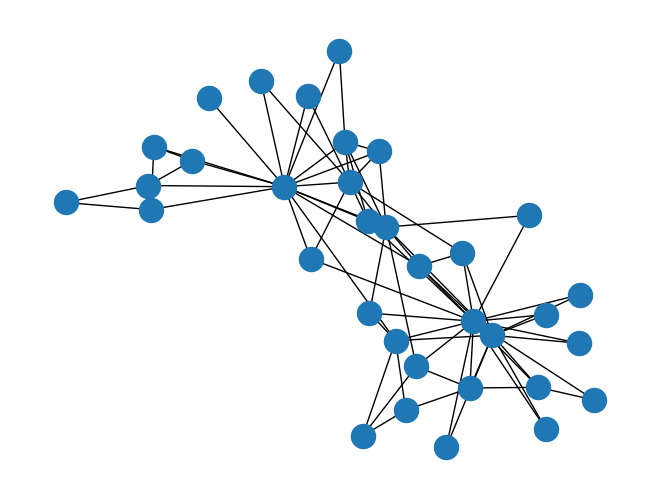

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate a network (NetworkX already provides a method to extract the Zachary's Karate Club data)
G = nx.karate_club_graph()

# Lets displace nodes following a Directed Force algorithm (remember Lecture 4, on Data Viz, and Lab 2 Aux)
pos = nx.spring_layout(G)

# Draw the original graph
nx.draw(G, pos=pos)

We're now going to play with an implementation of Community Detection offered by NetworkX, which will follow the same principles of Modularity Maximization lectured in [Lecture 7](https://canvas.uva.nl/courses/45979/files/11537488?module_item_id=2187507).

You can find extra details about function <code>greedy_modularity_communities</code> [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html).

In [2]:
from networkx.algorithms.community import greedy_modularity_communities

#the function will return a partition of nodes
c = list(greedy_modularity_communities(G, resolution=0.8))

print(c)

#we can inspecte the first element of the partition (e.g., nodes on community 1)
sorted(c[0])

[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21}), frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})]


[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21]

## Further delve into modularity:

In [9]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

gamma = 0.8
c = list(greedy_modularity_communities(G, resolution=gamma))
Q_final = modularity(G, c, resolution=gamma)

Q_singletons = modularity(G, [{v} for v in G], resolution=gamma)
Q_oneblock = modularity(G, [set(G.nodes)], resolution=gamma)

print(f"Q(final) = {Q_final:.4f}")
print(f"Q(singletons) = {Q_singletons:.4f}")
print(f"Q(one block) = {Q_oneblock:.4f}")

Q(final) = 0.5000
Q(singletons) = -0.0409
Q(one block) = 0.2000


**Q1: How many communities are identified? What is the impact of parameter resolution (now set to 0.8) on this value?**

(check the  greedy_modularity_communities documentation pointed above)

In [16]:
len(c)  #number of communities detected

2

**Q2: Can you plot the network with nodes colores based on communities?**

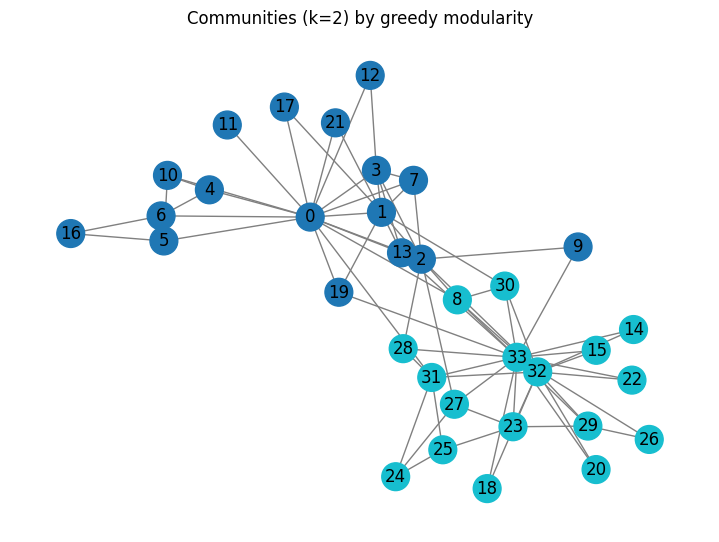

In [31]:
# Color nodes by detected communities in `c`
# Assumes `G`, `pos`, and `c` are already defined in earlier cells

# Map each node to its community index
node2comm = {n: i for i, comm in enumerate(c) for n in comm}

# Build color list following the iteration order of G.nodes()
node_colors = [node2comm[n] for n in G.nodes()]

plt.figure(figsize=(7, 5))
nx.draw(
    G,
    pos=pos,
    node_color=node_colors,
    cmap=plt.cm.tab10,
    with_labels=True,
    node_size=400,
    edge_color='gray'
)
plt.title(f"Communities (k={len(c)}) by greedy modularity")
plt.show()

<h2> Link Prediction - Auxiliary functions Assignment 2 </h2>

The next task we consider is link prediction. Link prediction will be at the core of your [Assignment 2](https://canvas.uva.nl/courses/45979/assignments/537063).

Predicting links on a network is fundamental to predict future connections in social networks or discover hidden connections in incomplete network data. You can find more info about link prediction on [Wikipedia](https://en.wikipedia.org/wiki/Link_prediction).


There are many approaches to link prediction, from simpler ones (based on heuristics and network similarity measures, also called topology-based approaches) to more complex ones (based on graph embeddings and deep learning).

The supervised learning methods you learned so far can also be used to perform link prediction. In your Assignment you should use supervised learning, in particular the techniques discussed in the course, to tackle the problem of link prediction. In the example below, you will try to predict links in the Karate Club network.

The network has  34  nodes
The network has  78  edges


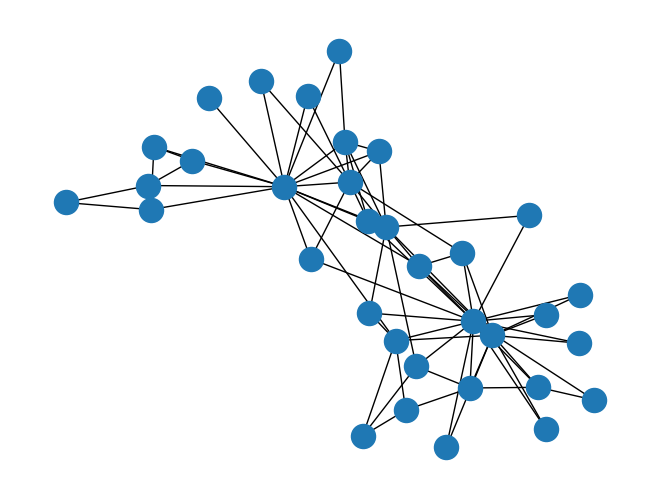

In [38]:
# Importing and exporting network data
import pandas as pd

# We will start by exporting and importing the Karate Club network
# This example can be useful for you to import the network data used in Assignment 2

edges = []
for edg in nx.edges(G):
    edges.append(edg)

dfEdges = pd.DataFrame(edges)
dfEdges.to_csv("karateclub.edgelist", index=False, header=False)

G1 = nx.read_edgelist("karateclub.edgelist", data=False, nodetype = int, delimiter=',') # import
nx.draw(G1, pos=pos)

#Compute number of nodes in the network
N = len(list(G1.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(G1.edges))
print("The network has ", E, " edges")

Above, we are creating a network by importing a list of edges in the exact same format as edges_train.edgelist for Assignment 2.

In the code below, we will create a training set by removing nEdgesRemove random edges from the network above. The removed links will be visualised in red.

The network has  34  nodes
The network has  69  edges


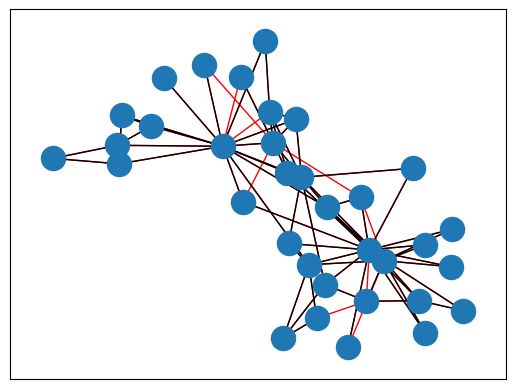

In [39]:
# We will now create a training set by removing nEdgesRemove random edges from the network above
# 10 edges will be removed
nEdgesRemove = 10

# Sample random edges
allEdges = np.array(G1.edges)
np.random.seed(seed=42)
selectEdges = np.random.choice(np.arange(allEdges.shape[0]), nEdgesRemove)
edgesToRemove = allEdges[selectEdges]

# Create new graph (H) without selected edges
H = G1.copy()
H.remove_edges_from(edgesToRemove)

# Visualize the links that were removed (in red)
# Use the same colors as defined above to color communities
for i in range(len(c)):
    nx.draw_networkx_nodes(G, pos, nodelist=sorted(c[i]))

nx.draw_networkx_edges(G, pos, edge_color='red')
nx.draw_networkx_edges(H, pos, edge_color='black')

#Compute number of nodes in the network
N = len(list(H.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(H.edges))
print("The network has ", E, " edges")

## Use Preferential Attachment between nodes as a feature

After importing the network the next task is to define the features that seem important to predict the occurence of links.

This is the step where feature engineering can take place. We are using [preferential attachment](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment) as one feature to infer links. This might not be the most interesting feature to predict links in this social network. Other possible features can be constructed by metrics you can learn about in the NetworkX documentation ([here](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html)).

**Q2: Which other features can you use? Adapt function *getFeature* to consider other features associated with each edge.**

## Code to get the most common Features (Incl. Preferent. Attach.), prepare for training on this X

In [44]:
# Use Preferential Attachment between nodes as a feature
pa = np.zeros((N,N))

preds = nx.preferential_attachment(H, [(i,j) for i in range(N) for j in range(N)])
for u, v, p in preds:
    pa[u,v] = p

# Also use other link-prediction similarities
from networkx.algorithms.link_prediction import (
    jaccard_coefficient,
    adamic_adar_index,
    resource_allocation_index,
)

def _first_score(gen, default=0.0):
    for _, _, s in gen:
        return float(s)
    return float(default)

# Generate features from edge endpoints
# Input: getFeature(graph, node_i, node_j)
def getFeature(G, i, j):
    # Core similarities
    cn  = sum(1 for _ in nx.common_neighbors(G, i, j))
    jac = _first_score(jaccard_coefficient(G, [(i, j)]))
    aa  = _first_score(adamic_adar_index(G, [(i, j)]))
    ra  = _first_score(resource_allocation_index(G, [(i, j)]))
    # Degrees and PA (precomputed)
    di, dj = G.degree(i), G.degree(j)
    pa_ij = pa[i, j] if i < pa.shape[0] and j < pa.shape[1] else di * dj
    return [pa_ij, cn, jac, aa, ra, di, dj]

## testing it (extra added)


In [49]:
# Pick one existing edge and one non-edge
e = next(iter(H.edges))
non_edges = [(u, v) for u in H.nodes() for v in H.nodes() if u < v and not H.has_edge(u, v)]
ne = non_edges[0]

# Feature vectors
fe_edge = getFeature(H, *e)
fe_non = getFeature(H, *ne)

print("Edge:", e, "features:", fe_edge, "len:", len(fe_edge))
print("Non-edge:", ne, "features:", fe_non, "len:", len(fe_non))

Edge: (0, 1) features: [np.float64(84.0), 3, 0.17647058823529413, 1.7769769369073454, 0.55, 14, 6] len: 7
Non-edge: (0, 3) features: [np.float64(70.0), 5, 0.35714285714285715, 3.777782604347556, 1.2166666666666666, 14, 5] len: 7


## Accuracy and AUC for Logistic regression:

In [54]:
# Build a balanced toy dataset
pos = list(H.edges)
neg = non_edges[:len(pos)]

X = [getFeature(H, i, j) for (i, j) in pos + neg]
Y = [1]*len(pos) + [0]*len(neg)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

Xtr, Xte, ytr, yte = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)

yprob = clf.predict_proba(Xte)[:, 1]
ypred = (yprob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(yte, ypred))
print("ROC AUC:", roc_auc_score(yte, yprob))

Accuracy: 0.6666666666666666
ROC AUC: 0.5453514739229024


### Build labeled edge sets (positives = removed edges from G; negatives = sampled non-edges in H)
We construct a labeled dataset of candidate edges using:
- Positive class (label=1): edges that existed in original graph `G` but were removed to create `H` (i.e., `edgesToRemove`).
- Negative class (label=0): pairs of nodes that are non-edges in `H` (and also not in `G`).

We will also plot them: training edges in `H` (gray), removed positives (red), and sampled negatives (blue dashed).

### Custom represent removed links and kept links. ofc you have that never existed

In [61]:
# Build labeled positive and negative edge sets
import random

# Positive edges: those removed from G to create H
positives = [(int(u), int(v)) for (u, v) in edgesToRemove]

# Candidate non-edges: pairs not present in H
nodes = list(H.nodes())
non_edges_all = [(u, v) for i, u in enumerate(nodes) for v in nodes[i+1:] if not H.has_edge(u, v)]

# Filter out any original edges from G to be strict negatives
strict_non_edges = [(u, v) for (u, v) in non_edges_all if not G.has_edge(u, v)]

# Sample as many negatives as positives for a balanced view (or min if insufficient)
neg_sample_size = min(len(positives), len(strict_non_edges))
random.seed(42)
negatives = random.sample(strict_non_edges, k=neg_sample_size)

print(f"Positives (removed): {len(positives)} | Negatives (sampled non-edges): {len(negatives)}")

# Optional: pack into a small DataFrame for inspection
import pandas as pd
labeled = pd.DataFrame(
    [(u, v, 1) for (u, v) in positives] + [(u, v, 0) for (u, v) in negatives],
    columns=["u", "v", "y"]
)
print(labeled.head())

Positives (removed): 10 | Negatives (sampled non-edges): 10
    u   v  y
0  30  32  1
1   0  21  1
2  33  23  1
3  32  18  1
4   1  17  1


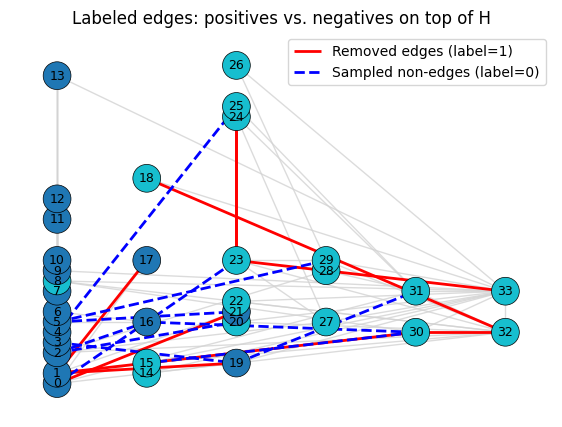

In [62]:
# Visualize: H edges (gray), positives (red), negatives (blue dashed)
plt.figure(figsize=(7, 5))

# Draw base graph H in light gray
nx.draw_networkx_edges(H, pos=pos, edge_color='lightgray', alpha=0.8)

# Draw nodes colored by community
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, edgecolors='black', linewidths=0.5)

# Overlay positives (removed edges from G)
nx.draw_networkx_edges(G, pos=pos, edgelist=positives, edge_color='red', width=2, label='Removed edges (label=1)')

# Overlay negatives (sampled non-edges)
nx.draw_networkx_edges(G, pos=pos, edgelist=negatives, edge_color='blue', style='dashed', width=2, label='Sampled non-edges (label=0)')

# Labels and legend
nx.draw_networkx_labels(G, pos=pos, font_size=9)
plt.title('Labeled edges: positives vs. negatives on top of H')
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

## Create negative set. Split for training. Train and Test

The next step is to create a training set. You can do this by using all visible edges in network H (positive examples) and some non-existing edges in network H (negative examples).

In [63]:
""" # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
X = []
Y = []

# Add positive examples where edge exist
for (i, j) in H.edges:
    X.append(getFeature(H, i, j))
    Y.append(1)

# Add negative examples where edge does not exist
# Reflect: how many negative examples should you include?
for kk in range(200):
        i = np.random.randint(N)
        j = np.random.randint(N)

        while H.has_edge(i,j) or i == j:
            i = np.random.randint(N)
            j = np.random.randint(N)

        X.append(getFeature(H, i, j))
        Y.append(0) """

In [67]:
NEG_POS_RATIO = 2  # try 1, 2, 5
rng = np.random.default_rng(42)

X, Y = [], []

# Positives: existing edges in H
positives = list(H.edges())
n_pos = len(positives)

# Candidate non-edges in H
nodes = list(H.nodes())
non_edges_all = [(u, v) for i, u in enumerate(nodes) for v in nodes[i+1:] if not H.has_edge(u, v)]

# Sample negatives according to the ratio
n_neg = min(NEG_POS_RATIO * n_pos, len(non_edges_all))
negatives = list(rng.choice(non_edges_all, size=n_neg, replace=False))

# Build dataset
for (i, j) in positives:
    X.append(getFeature(H, i, j))
    Y.append(1)

for (i, j) in negatives:
    X.append(getFeature(H, i, j))
    Y.append(0)

## Preview X and Y

In [88]:
feature_names = ["PA", "CN", "Jaccard", "AdamicAdar", "ResAlloc", "deg_i", "deg_j"]
print("X_train shape:", np.asarray(X_train).shape)
print(dict(zip(feature_names, clf.coef_[0])))

X_train shape: (41, 7)
{'PA': np.float64(0.2577630487537594), 'CN': np.float64(-0.40275876408518996), 'Jaccard': np.float64(-0.11348251377345382), 'AdamicAdar': np.float64(-0.16686563951299563), 'ResAlloc': np.float64(-0.036242628781449605), 'deg_i': np.float64(0.47115667234634223), 'deg_j': np.float64(-0.4141950614844098)}


PA summary (overall):
count    207.000000
mean      20.975845
std       23.966084
min        1.000000
25%        6.000000
50%       12.000000
75%       28.000000
max      160.000000
Name: PA, dtype: float64

PA summary by class (y=1 positive, y=0 negative):
   count       mean        std  min   25%   50%   75%    max
y                                                           
0  138.0  12.144928  12.832754  1.0   4.0   8.0  15.0   96.0
1   69.0  38.637681  30.552256  6.0  16.0  32.0  50.0  160.0


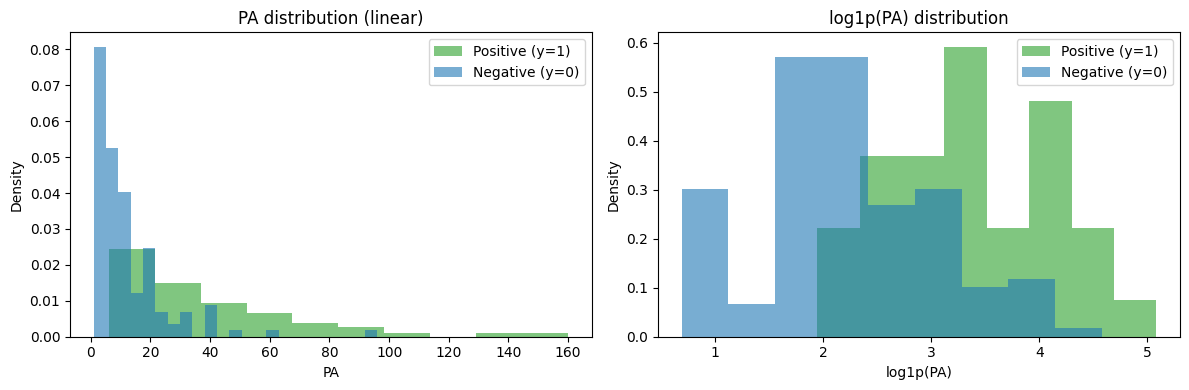

C:\Users\mariu\AppData\Local\Temp\ipykernel_34320\640443408.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log1p(pa_neg), np.log1p(pa_pos)], labels=['y=0', 'y=1'], showfliers=False)


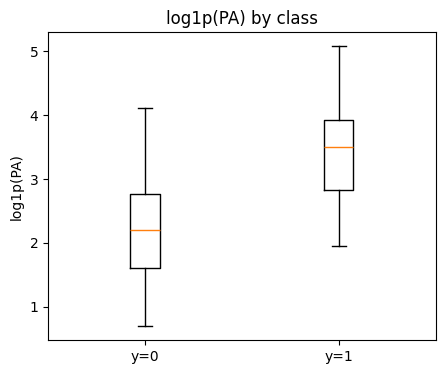

In [158]:
#what is the distribution of the Feature PA values in the X data ?
# ...existing code...
# what is the distribution of the Feature PA values in the X data ?
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

if 'X' not in globals() or 'Y' not in globals() or len(X) == 0:
    raise RuntimeError("Build X and Y first (run the dataset creation cell).")

X_arr = np.asarray(X, dtype=float)
Y_arr = np.asarray(Y, dtype=int)
PA = X_arr[:, 0]

# Summary stats overall and by class
df_pa = pd.DataFrame({'PA': PA, 'y': Y_arr})
print("PA summary (overall):")
print(df_pa['PA'].describe())
print("\nPA summary by class (y=1 positive, y=0 negative):")
print(df_pa.groupby('y')['PA'].describe())

# Split for plots
pa_pos = df_pa.loc[df_pa.y == 1, 'PA'].to_numpy()
pa_neg = df_pa.loc[df_pa.y == 0, 'PA'].to_numpy()

# Plots: linear scale and log1p scale for heavy tails
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale histogram
bins = 'auto'
axes[0].hist(pa_pos, bins=bins, alpha=0.6, label='Positive (y=1)', color='tab:green', density=True)
axes[0].hist(pa_neg, bins=bins, alpha=0.6, label='Negative (y=0)', color='tab:blue', density=True)
axes[0].set_title('PA distribution (linear)')
axes[0].set_xlabel('PA')
axes[0].set_ylabel('Density')
axes[0].legend()

# Log1p scale histogram
axes[1].hist(np.log1p(pa_pos), bins=bins, alpha=0.6, label='Positive (y=1)', color='tab:green', density=True)
axes[1].hist(np.log1p(pa_neg), bins=bins, alpha=0.6, label='Negative (y=0)', color='tab:blue', density=True)
axes[1].set_title('log1p(PA) distribution')
axes[1].set_xlabel('log1p(PA)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

# Optional: simple boxplot on log1p scale
plt.figure(figsize=(5, 4))
plt.boxplot([np.log1p(pa_neg), np.log1p(pa_pos)], labels=['y=0', 'y=1'], showfliers=False)
plt.title('log1p(PA) by class')
plt.ylabel('log1p(PA)')
plt.show()
# ...existing code...


## Discussion of PA characteristics:
* If PA is useful, the y=1 curve shifts right.
* Copilot: Does the number of 0s matter: for the per‑class histograms you’re plotting with density=True, class count doesn’t change the shape (just variance). What matters more is how you sampled negatives (uniform vs “hard” negatives). Class counts do affect model training (intercept/threshold) and accuracy; prefer ROC AUC/PR that are insensitive to priors, or use class_weight='balanced'.



# Question 3

**Q3: In the previous code we are adding 200 negative examples (non-existing edges) to our traning set. Is that a reasonable choice? How many positive examples are we considering?**

68 in the lightened graph H, and a ratio of 2:1, so 136 negative examples.

In [159]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42)

In [160]:
# Tune model (Logistic Regression)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, C=2)
clf.fit(X_train, y_train)
clf_lr = clf  # keep fitted LR for later predictions


scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.06


**Q4: The previous code trains a Logistic regression with a specific hyper-parameter. Which other learning models could you use, out of the ones discussed in the course? How could you select the best hyper-parameter?**

GitHub Copilot

Good alternatives (with small graphs, keep models simple and regularized):

* Linear SVM (with scaling): strong margin, good on small data.
* RBF SVM: flexible; use probability=True and scale features.
* Decision Tree: interpretable; keep max_depth small.
* Random Forest / Extra Trees: robust, low tuning; limit depth/trees.
* Gradient Boosting (sklearn): strong on tabular; shallow trees, small learning_rate.
* kNN (with scaling): simple baseline; can overfit on tiny data.
* MLPClassifier: tiny network with strong regularization.

Tips:
* Scale features for SVM/MLP/kNN; trees don’t need it.
* Use StratifiedKFold CV with ROC AUC (or Average Precision).

If imbalance, try class_weight='balanced' (LR/SVM).

In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

X_arr, Y_arr = np.asarray(X), np.asarray(Y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {

    "SVC-RBF": make_pipeline(RobustScaler(), SVC(C=1.0, gamma='scale', probability=True, random_state=0)),
    "GB": GradientBoostingClassifier(random_state=0),
    "kNN": make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=5)),
    "MLP": make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(16,), alpha=1e-2, max_iter=2000, random_state=0)),
}

for name, clf in models.items():
    acc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='roc_auc').mean()
    print(f"{name}: Accuracy={acc:.2f} ROC AUC={auc:.3f}")

    #robust scaler: an improvement of around 0.79->0.82 in at least 2/4 models

SVC-RBF: Accuracy=0.83 ROC AUC=0.855
GB: Accuracy=0.83 ROC AUC=0.894
kNN: Accuracy=0.80 ROC AUC=0.827
MLP: Accuracy=0.82 ROC AUC=0.883


## For a given list of edges (CSV), show the prediction based on our model

Given a list of edges, we should be able to predict its existence. Below we provide an example of importing an input file and returning, for edge, the prediction of the trained model.

**Q5: Please complete the missing text to generate the predictions from your model given the input data.**

In [162]:
# Return Solution

inpTest = pd.read_csv('aux_assignment2_testInput.csv', sep=',', index_col="ID")
pairs = [tuple(map(int, row)) for row in inpTest.to_numpy()]

# IDEALLY you want to be using the new graph with negative edges created, and then lookup what kind of edge it is?
# Fast workaround, does prediction still work and lookup?

# Ensure nodes exist in H to avoid "u is not in the graph"
for u, v in pairs:
    if u not in H: H.add_node(u)
    if v not in H: H.add_node(v)

# Build features and predict
inp = [getFeature(H, u, v) for (u, v) in pairs]
predictionsLR = clf_lr.predict(inp)


In [163]:
# Output solution
pd.DataFrame(predictionsLR).to_csv('aux_assignment2_predictions.csv', index=True, header=["prediction"], index_label="ID")

In [164]:
# Evaluate solution

# Read predictions
y_pred = pd.read_csv('aux_assignment2_predictions.csv', sep=',', index_col="ID")
y_pred = np.array(y_pred)

# Read solutions file
y = pd.read_csv('aux_assignment2_solution.csv', sep=',', index_col="ID")
y = np.array(y)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy (test): %0.3f%% " % (accuracy * 100))

Accuracy (test): 55.000% 


**Q6: Reflect on the accuracy value you obtained. What does that mean? Knowing that in the final test set there are 50% of positive examples and 50% of negative examples, what would be the accuracy of a random classifier? What would be the accuracy of a naive classifier always predicting that a link does not exist?**

## Reflection
Accuracy looks at the proportion of correct predictions (both true positives and true negatives) out of all predictions made. Given that there are 2x more negatives than positives, a model that predicts all negatives would achieve high accuracy (about 66.7%) but would fail to identify any positive links, which is often the more critical task in link prediction.

Our training set had 68 positive and 136 negative samples. A random classifier would have an expected accuracy of 50% on a balanced test set, while a naive classifier always predicting no link would achieve 0% accuracy on the balanced test set. Thus, our model's accuracy should be significantly higher than these baselines to be considered effective.

We had an external test of 20 samples, while our model achieved an accuracy of 55% on this test set. This indicates that our model is performing better than random guessing and the naive approach, but the small amount of data could be restricting its performance.

The author also looks forward toward using other classification algorithms on a bigger dataset.

## BUG/ Extra: Sampling of negatives affects performance!!! Both its count and its even-ness - or FAIRness ???
* What matters more is how you sampled negatives (uniform vs “hard” negatives). 
* Class counts do affect model training (intercept/threshold) and accuracy; prefer ROC AUC/PR that are insensitive to priors, or use class_weight='balanced'.

## Extra: See whether other algos perform better on this small set.

## Extra: Understand where goes wrong by seeing which edges and nodes commonly mistaken.
compare features...

## Extra: Visualize which predictions were correct vs. wrong on the test set
We re-associate each feature row with its node pair, compute predictions on `X_test`, and overlay:
- True positives (existing edges predicted 1): green solid
- False negatives (existing edges predicted 0): orange solid
- False positives (non-edges predicted 1): red dashed
- True negatives (non-edges predicted 0): blue dashed (light)

In [165]:
#error: index out of range.

""" # Build a mirrored dataset of node pairs aligned to X and Y so we can split and visualize
pairs_all = positives + negatives
assert len(pairs_all) == len(X) == len(Y)

# Train/test split that also returns the corresponding pairs
X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X, Y, pairs_all, test_size=0.3, random_state=42, stratify=Y
)

# Fit LR (use a simple, reproducible model)
from sklearn.linear_model import LogisticRegression
viz_clf = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
viz_clf.fit(X_train, y_train)

# Predict on test set
y_prob = viz_clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Partition edges by outcome
TP = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 1 and yp == 1]
FN = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 1 and yp == 0]
FP = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 0 and yp == 1]
TN = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 0 and yp == 0]

print(f"TP={len(TP)} FN={len(FN)} FP={len(FP)} TN={len(TN)}")

# Draw base graph H
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(H, pos=pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=350, edgecolors='black', linewidths=0.4)
nx.draw_networkx_edges(H, pos=pos, edge_color='lightgray', alpha=0.6)

# Overlay each category
if TP:
    nx.draw_networkx_edges(H, pos=pos, edgelist=TP, edge_color='green', width=2.5, label='TP (edge, predicted 1)')
if FN:
    nx.draw_networkx_edges(H, pos=pos, edgelist=FN, edge_color='orange', width=2.5, label='FN (edge, predicted 0)')
if FP:
    nx.draw_networkx_edges(H, pos=pos, edgelist=FP, edge_color='red', style='dashed', width=2.5, label='FP (non-edge, predicted 1)')
if TN:
    nx.draw_networkx_edges(H, pos=pos, edgelist=TN, edge_color='steelblue', style='dashed', alpha=0.7, width=2.0, label='TN (non-edge, predicted 0)')

nx.draw_networkx_labels(H, pos=pos, font_size=9)
plt.title('Test-set prediction outcomes on H')
plt.legend(loc='upper right')
plt.axis('off')
plt.show() """

' # Build a mirrored dataset of node pairs aligned to X and Y so we can split and visualize\npairs_all = positives + negatives\nassert len(pairs_all) == len(X) == len(Y)\n\n# Train/test split that also returns the corresponding pairs\nX_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(\n    X, Y, pairs_all, test_size=0.3, random_state=42, stratify=Y\n)\n\n# Fit LR (use a simple, reproducible model)\nfrom sklearn.linear_model import LogisticRegression\nviz_clf = LogisticRegression(max_iter=1000, C=1.0, random_state=42)\nviz_clf.fit(X_train, y_train)\n\n# Predict on test set\ny_prob = viz_clf.predict_proba(X_test)[:, 1]\ny_pred = (y_prob >= 0.5).astype(int)\n\n# Partition edges by outcome\nTP = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 1 and yp == 1]\nFN = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 1 and yp == 0]\nFP = [e for e, yt, yp in zip(pairs_test, y_test, y_pred) if yt == 0 and yp == 1]\nTN = [e for e, yt, yp in zip(pa